#Why we changed our dataset

We initially used a custom LinkedIn job postings dataset. However, during Phase 1 exploration, we found that the dataset required extensive manual cleaning and restructuring. Many columns were irrelevant to our learning objective, skill data was stored in inconsistent formats, and the preprocessing effort would exceed the scope of this project.
For these reasons, we switched to the Hugging Face dataset https://huggingface.co/datasets/lukebarousse/data_jobs , which is cleaner, more structured, and better aligned with our goals.



# Algorithm Selection & Justification

We selected Linear Support Vector Machine (SVM) and Logistic Regression as our supervised learning models because they are highly effective for short-text classification tasks. Our input features are job titles (plus country), which become high-dimensional and sparse after TF-IDF vectorization. Linear SVM is well known for its strong performance on this type of text data and handles label imbalance effectively using class weighting. Logistic Regression is also a strong baseline model for sparse text and provides probability based predictions, making it useful for ranking skills and selecting the top relevant ones. Both models scale efficiently to a multi-label problem using One-vs-Rest classification. Compared to more complex models like Neural Networks or Decision Trees, SVM and Logistic Regression provide faster training, easier interpretation, and reliable performance given our dataset size and project scope. Therefore, they represent the best balance between accuracy, efficiency, and explainability for predicting multiple skills from job titles.

In [ ]:
# Install for notebook
!pip -q install datasets

# Import and load
from datasets import load_dataset

ds = load_dataset("lukebarousse/data_jobs")
train = ds["train"]

# 3) Peek
train, len(train), train.column_names[:10]

import pandas as pd
df = train.to_pandas()
df.head()

# Display first 5 rows
print("\n Preview of the dataset:")
display(df.head())


 Preview of the dataset:


,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,None,NaN,NaN,Boehringer Ingelheim,None,None
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,None,NaN,NaN,Hewlett Packard Enterprise,"['r', 'python', 'sql', 'nosql', 'power bi', 't...","{'analyst_tools': ['power bi', 'tableau'], 'pr..."
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,None,NaN,NaN,ALPHA Augmented Services,"['python', 'sql', 'c#', 'azure', 'airflow', 'd...","{'analyst_tools': ['dax'], 'cloud': ['azure'],..."
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"San Antonio, TX",via Diversity.com,Full-time,False,"Texas, United States",2023-07-04 13:01:41,True,False,United States,None,NaN,NaN,Southwest Research Institute,"['python', 'c++', 'java', 'matlab', 'aws', 'te...","{'cloud': ['aws'], 'libraries': ['tensorflow',..."
4,Data Engineer,Data Engineer- Sr Jobs,"Washington, DC",via Clearance Jobs,Full-time,False,Sudan,2023-08-07 14:29:36,False,False,Sudan,None,NaN,NaN,Kristina Daniel,"['bash', 'python', 'oracle', 'aws', 'ansible',...","{'cloud': ['oracle', 'aws'], 'other': ['ansibl..."


###Handle Missing Values and Cleaning

In [ ]:
import re, ast, numpy as np, pandas as pd
from collections import Counter

# keep only job_title_short, job_country and job_skills
def clean_datajobs(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=[
        "job_title","job_location", "job_via",
        "job_schedule_type","job_work_from_home","search_location",
        "job_posted_date","job_no_degree_mention","job_health_insurance",
        "salary_rate","salary_year_avg","salary_hour_avg",
        "company_name","job_type_skills"
    ], errors="ignore").copy()

    # for job_country fill missing with unknown and normalize
    if "job_country" in df.columns:
        df["job_country"] = (
            df["job_country"]
              .replace({"": np.nan, "nan": np.nan, None: np.nan})
              .fillna("unknown")
              .astype(str).str.strip().str.lower()
        )

    # for job_title_short only normalize since there are no missing value there
    if "job_title_short" in df.columns:
        df["job_title_short"] = (
            df["job_title_short"].astype(str).str.strip().str.lower()
        )

    # for job_skills keep it as string list and clean items
    def to_skill_list(x):
        """Return clean list[str] from list/tuple/set or a stringified list."""
        if x is None or (isinstance(x, float) and pd.isna(x)):
            return []
        if isinstance(x, (list, tuple, set)):
            seq = list(x)
        elif isinstance(x, str):
            try:
                parsed = ast.literal_eval(x)
                if isinstance(parsed, (list, tuple, set)):
                    seq = list(parsed)
                else:
                    seq = re.split(r"[;,/|]", x)
            except Exception:
                seq = re.split(r"[;,/|]", x)
        else:
            return []

        out = []
        for s in seq:
            if s is None:
                continue
            s = str(s).lower()
            s = s.strip()
            s = re.sub(r"^[\s\W_]+|[\s\W_]+$", "", s)
            s = re.sub(r"\s+", " ", s)
            if len(s) >= 2:
                out.append(s)
        seen = set(); uniq = []
        for s in out:
            if s not in seen:
                seen.add(s); uniq.append(s)
        return uniq
    if "job_skills" not in df.columns:
        raise ValueError("Expected column 'job_skills' in dataframe.")
    df = df[df["job_skills"].notna()].copy()
    df["job_skills"] = df["job_skills"].apply(to_skill_list)

    # drop rows with empty skill list
    df = df[df["job_skills"].apply(len) > 0].reset_index(drop=True)

    # quick checks
    assert df["job_skills"].map(type).eq(list).all(), "job_skills must be list after cleaning"
    if "job_title_short" in df.columns:
        assert df["job_title_short"].map(type).eq(str).all()

    return df

df = clean_datajobs(df)
# Quick preview
print(df.shape)
print(df.head)


(666021, 3)
<bound method NDFrame.head of           job_title_short    job_country  \
0            data analyst         mexico   
1           data engineer        germany   
2           data engineer  united states   
3           data engineer          sudan   
4           data engineer  united states   
...                   ...            ...   
666016  software engineer      singapore   
666017       data analyst        germany   
666018   business analyst       malaysia   
666019      data engineer          sudan   
666020  software engineer          india   

                                               job_skills  
0                 [python, sql, nosql, power bi, tableau]  
1       [python, sql, azure, airflow, dax, docker, kub...  
2       [python, java, matlab, aws, tensorflow, keras,...  
3       [bash, python, oracle, aws, ansible, puppet, j...  
4                                      [python, sql, gcp]  
...                                                   ...  
666016  [

In [ ]:
from collections import Counter
# in our data set there is around 1777 skills which make it difficult for even predict so we round it to the top 30 skills to be able to predict safely
# also to reduce the overlapping
all_skills = [s for row in df["job_skills"] for s in row]
skill_counts = Counter(all_skills)
print("\nTop 30 most common skills: ")
for i, (skill, cnt) in enumerate(skill_counts.most_common(30), 1):
    print(f"{i:2d}. {skill:20s} ({cnt} times)")

top_n = 30
top_skills = {s for s, _ in skill_counts.most_common(top_n)}

# Keep only rows that have at least one of the top 30 skills to et rid of the unused skilles
mask_has_top = df["job_skills"].apply(lambda L: any(s in top_skills for s in L))
df_top = df[mask_has_top].copy()

# keep only skills that are in Top 30
df_top["job_skills"] = df_top["job_skills"].apply(lambda L: [s for s in L if s in top_skills])

# Drop rows with empty skill lists
df_top = df_top[df_top["job_skills"].map(len) > 0].reset_index(drop=True)

#check
assert df_top["job_skills"].apply(len).gt(0).all(), "Found a row with no top skills after filtering!"
assert set().union(*df_top["job_skills"]) <= top_skills, "Some skills outside Top-30 leaked in."



print(f"Rows before: {len(df)}")
print(f"Rows after : {len(df_top)}")
print("Done.")



Top 30 most common skills: 
 1. sql                  (384849 times)
 2. python               (380909 times)
 3. aws                  (145381 times)
 4. azure                (132527 times)
 5. tableau              (127213 times)
 6. excel                (127018 times)
 7. spark                (114609 times)
 8. power bi             (98147 times)
 9. java                 (85612 times)
10. hadoop               (64842 times)
11. scala                (56886 times)
12. snowflake            (55015 times)
13. databricks           (53182 times)
14. gcp                  (50727 times)
15. git                  (50226 times)
16. kafka                (49926 times)
17. airflow              (45254 times)
18. oracle               (45221 times)
19. nosql                (45070 times)
20. docker               (41715 times)
21. sas                  (41702 times)
22. sql server           (40197 times)
23. go                   (38634 times)
24. kubernetes           (37349 times)
25. redshift             (33

In [ ]:
display(df_top.head()) # only top 30 skilles

,job_title_short,job_country,job_skills
0,data analyst,mexico,"[python, sql, nosql, power bi, tableau]"
1,data engineer,germany,"[python, sql, azure, airflow, docker, kubernetes]"
2,data engineer,united states,"[python, java, aws, tensorflow]"
3,data engineer,sudan,"[python, oracle, aws, git]"
4,data engineer,united states,"[python, sql, gcp]"


In [ ]:
import numpy as np, pandas as pd, re
from collections import Counter

# make sure that there is no rows that don't have any skills
y_lists = df_top["job_skills"]
mask = y_lists.apply(len) > 0
df_top = df_top[mask].reset_index(drop=True)
y_lists = y_lists[mask].reset_index(drop=True)
print(f"Filtered to {len(df_top)} rows with skills\n")

#for every country, it has 50 from every job title to make the data balanced
X_PER_COUNTRY = 50   # target per (title, country)
RSEED = 42

_tmp = df_top.copy()
_tmp["__labels__"] = y_lists

parts = []
for (title, country), sub in _tmp.groupby(["job_title_short", "job_country"], dropna=False):
    if len(sub) >= X_PER_COUNTRY:
        parts.append(sub.sample(n=X_PER_COUNTRY, random_state=RSEED, replace=False))
    else:
        parts.append(sub.sample(n=X_PER_COUNTRY, random_state=RSEED, replace=True))

_tmp_bal = pd.concat(parts, ignore_index=True)

df_top = _tmp_bal.drop(columns="__labels__")
y_lists = _tmp_bal["__labels__"].reset_index(drop=True)

print(f" Balanced by (job_title_short, job_country): {len(df_top)} rows "
      f"(target {X_PER_COUNTRY} per group)")

#after balancing it and ready to be processed
display(df_top.head())

Filtered to 641294 rows with skills

🔧 Balanced by (job_title_short, job_country): 67300 rows (target 50 per group)


,job_title_short,job_country,job_skills
0,business analyst,afghanistan,"[go, oracle]"
1,business analyst,afghanistan,[sas]
2,business analyst,afghanistan,"[go, oracle]"
3,business analyst,afghanistan,"[go, oracle]"
4,business analyst,afghanistan,[sas]


## Implementation for Supervised Learning Model

ready: train shape = (53840, 2308)

Logistic Regression trained

SVM trained


Evaluating LogReg 
Threshold 0.10  Acc=0.0960  F1w=0.4389  Prec=0.3077  Rec=0.9823
Threshold 0.15  Acc=0.1112  F1w=0.4471  Prec=0.3161  Rec=0.9761
Threshold 0.20  Acc=0.1132  F1w=0.4545  Prec=0.3254  Rec=0.9653
Threshold 0.25  Acc=0.1132  F1w=0.4656  Prec=0.3382  Rec=0.9471
Threshold 0.30  Acc=0.1134  F1w=0.4757  Prec=0.3521  Rec=0.9232
Threshold 0.35  Acc=0.1146  F1w=0.4843  Prec=0.3661  Rec=0.8996
Threshold 0.40  Acc=0.1152  F1w=0.4923  Prec=0.3817  Rec=0.8689
Threshold 0.45  Acc=0.1147  F1w=0.4991  Prec=0.3986  Rec=0.8320
Threshold 0.50  Acc=0.1143  F1w=0.5028  Prec=0.4153  Rec=0.7892
Threshold 0.55  Acc=0.1154  F1w=0.5046  Prec=0.4358  Rec=0.7362
Threshold 0.60  Acc=0.1181  F1w=0.5009  Prec=0.4594  Rec=0.6735
Threshold 0.65  Acc=0.1233  F1w=0.4905  Prec=0.4876  Rec=0.6010
Threshold 0.70  Acc=0.1320  F1w=0.4759  Prec=0.5244  Rec=0.5214
Threshold 0.75  Acc=0.1400  F1w=0.4513  Prec=0.5764  Rec=0.4312
Thresh

,model,best_threshold,subset_acc,micro_f1,macro_f1,samples_jaccard,hamming_loss,lrap,precision_weighted,recall_weighted,f1_weighted
1,SVM,0.25,0.137296,0.561050,0.442640,0.430661,0.127008,0.684947,0.479298,0.667237,0.547918
0,LogReg,0.55,0.115379,0.439617,0.386916,0.348100,0.228323,0.556702,0.435792,0.736208,0.504609


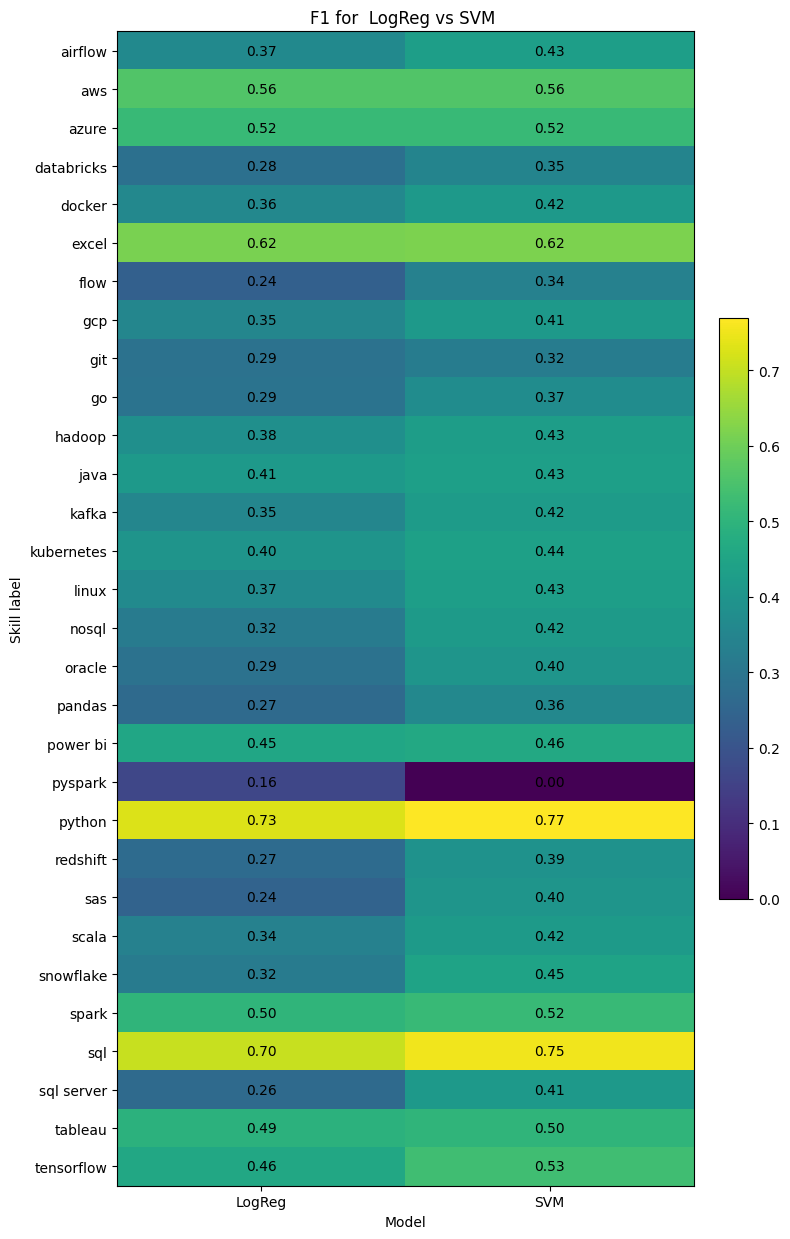


Sample Predictions (LogReg vs SVM):

( software engineer liberia
    Actual=    ['python', 'aws']
    LogReg=    ['aws', 'flow', 'gcp', 'go', 'java', 'kubernetes', 'linux', 'pandas', 'python', 'redshift']   (match 100%)
    SVM=      ['aws', 'java', 'kubernetes', 'python']  (match 100%)
....................................................................................................
( software engineer tanzania
    Actual=    ['python', 'go', 'azure', 'databricks']
    LogReg=    ['azure', 'databricks', 'git', 'go', 'java']   (match 75%)
    SVM=      ['git', 'java', 'python']  (match 25%)
....................................................................................................
( cloud engineer peru
    Actual=    ['python', 'sql', 'pandas', 'flow']
    LogReg=    ['aws', 'azure', 'databricks', 'docker', 'flow', 'kubernetes', 'linux', 'pyspark', 'scala', 'sql server']   (match 25%)
    SVM=      ['aws', 'azure', 'kubernetes', 'sql']  (match 25%)
.........................

In [ ]:
  #defining the input and the output

X_text = (
    df_top["job_title_short"].fillna("").astype(str) + " " +
    df_top.get("job_country", pd.Series("", index=df_top.index)).fillna("").astype(str)
).str.strip()

# split the training and testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_lists, test_size=0.2, random_state=42, shuffle=True
)

mlb = MultiLabelBinarizer()
mlb.fit(y_lists)
label_names = mlb.classes_

y_train_encoded = mlb.transform(y_train)   # (n_train, n_labels)
y_test_encoded  = mlb.transform(y_test)    # (n_test,  n_labels)

# Vectorize + Scale
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler

tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 4),
    min_df=2,
    max_df=0.8,
    sublinear_tf=True,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{2,}\b'
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

scaler = MaxAbsScaler()
X_train_tfidf = scaler.fit_transform(X_train_tfidf)
X_test_tfidf  = scaler.transform(X_test_tfidf)
print(f"ready: train shape = {X_train_tfidf.shape}\n")


# training for Logistic Regression
from sklearn.linear_model import LogisticRegression
def fit_lr_per_label(X, Y):
    ests = []
    for j in range(Y.shape[1]):
        lr = LogisticRegression(
            solver='liblinear',
            C=2.0,
            class_weight='balanced',
            max_iter=1000
        )
        lr.fit(X, Y[:, j])
        ests.append(lr)
    return ests

def predict_proba_stack(estimators, X):
    return np.column_stack([est.predict_proba(X)[:, 1] for est in estimators])
lr_ests = fit_lr_per_label(X_train_tfidf, y_train_encoded)
print("Logistic Regression trained\n")

# trainnig for SVM
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

def fit_svm_calibrated_per_label(X, Y):
    ests = []
    for j in range(Y.shape[1]):
        base = LinearSVC(C=1.0, class_weight='balanced')
        cal  = CalibratedClassifierCV(estimator=base, method="sigmoid", cv=3)
        cal.fit(X, Y[:, j])
        ests.append(cal)
    return ests

svm_ests = fit_svm_calibrated_per_label(X_train_tfidf, y_train_encoded)
print("SVM trained\n")

# Threshold sweep, metrics, readable outputs
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    hamming_loss, jaccard_score, classification_report,
    label_ranking_average_precision_score
)
import matplotlib.pyplot as plt

def sweep_metrics(y_true_bin, y_proba, thresholds=np.arange(0.1, 0.9, 0.05)):
    rows, best = [], {"f1w": -1, "thr": None, "pred": None}
    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        acc  = accuracy_score(y_true_bin, y_pred)
        f1w  = f1_score(y_true_bin, y_pred, average='weighted', zero_division=0)
        prec = precision_score(y_true_bin, y_pred, average='weighted', zero_division=0)
        rec  = recall_score(y_true_bin, y_pred, average='weighted', zero_division=0)
        rows.append({"threshold": thr, "subset_acc": acc, "f1_weighted": f1w,
                     "precision_weighted": prec, "recall_weighted": rec})
        if f1w > best["f1w"]:
            best = {"f1w": f1w, "thr": thr, "pred": y_pred}
    return pd.DataFrame(rows), best["thr"], best["pred"]

def eval_model(name, y_proba, y_true_bin, label_names):
    print(f"\nEvaluating {name} ")
    hist, best_thr, y_pred_bin = sweep_metrics(y_true_bin, y_proba)

    # Compact sweep print
    for _, r in hist.iterrows():
        print(f"Threshold {r['threshold']:.2f}  "
              f"Acc={r['subset_acc']:.4f}  F1w={r['f1_weighted']:.4f}  "
              f"Prec={r['precision_weighted']:.4f}  Rec={r['recall_weighted']:.4f}")

    best_row = hist.loc[hist['threshold'] == best_thr].iloc[0]
    print(f"\nBest threshold for {name}: {best_thr:.2f} (F1w={best_row['f1_weighted']:.4f})")

    micro_f1   = f1_score(y_true_bin, y_pred_bin, average="micro",  zero_division=0)
    macro_f1   = f1_score(y_true_bin, y_pred_bin, average="macro",  zero_division=0)
    samples_j  = jaccard_score(y_true_bin, y_pred_bin, average="samples", zero_division=0)
    ham        = hamming_loss(y_true_bin, y_pred_bin)
    subset_acc = accuracy_score(y_true_bin, y_pred_bin)
    try:
        lrap = label_ranking_average_precision_score(y_true_bin, y_proba)
    except Exception:
        lrap = np.nan

    print("\nreport:")
    print(classification_report(y_true_bin, y_pred_bin, target_names=label_names, zero_division=0))

    summary = {
        "model": name,
        "best_threshold": best_thr,
        "subset_acc": subset_acc,
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "samples_jaccard": samples_j,
        "hamming_loss": ham,
        "lrap": lrap,
        "f1_weighted": best_row["f1_weighted"],
        "precision_weighted": best_row["precision_weighted"],
        "recall_weighted": best_row["recall_weighted"],
    }
    return summary, hist, y_pred_bin

# probabilities
y_proba_lr  = predict_proba_stack(lr_ests,  X_test_tfidf)  # (n_test, n_labels)
y_proba_svm = predict_proba_stack(svm_ests, X_test_tfidf)

# evaluate
sum_lr,  hist_lr,  y_pred_lr  = eval_model("LogReg", y_proba_lr,  y_test_encoded, label_names)
sum_svm, hist_svm, y_pred_svm = eval_model("SVM ", y_proba_svm, y_test_encoded, label_names)

#comparison table
summary_df = pd.DataFrame([sum_lr, sum_svm])[
    ["model","best_threshold","subset_acc","micro_f1","macro_f1",
     "samples_jaccard","hamming_loss","lrap","precision_weighted","recall_weighted","f1_weighted"]
].sort_values("f1_weighted", ascending=False)
print("\n (best threshold per model)")
try:
    display(summary_df)
except NameError:
    print(summary_df)

# Heatmap F1 (LogReg vs SVM)
from sklearn.metrics import f1_score
f1_lr  = f1_score(y_test_encoded, y_pred_lr,  average=None, zero_division=0)
f1_svm = f1_score(y_test_encoded, y_pred_svm, average=None, zero_division=0)

M_labels = np.vstack([f1_lr, f1_svm])
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 0.35*len(label_names)+2))
im = ax.imshow(M_labels.T, aspect="auto")
ax.set_title("F1 for  LogReg vs SVM ")
ax.set_xlabel("Model"); ax.set_ylabel("Skill label")
ax.set_xticks([0,1]); ax.set_xticklabels(["LogReg","SVM"])
ax.set_yticks(range(len(label_names))); ax.set_yticklabels(label_names)
for i in range(M_labels.shape[1]):
    for j in range(M_labels.shape[0]):
        ax.text(j, i, f"{M_labels[j, i]:.2f}", ha="center", va="center")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# Sample predictions (LogReg vs SVM)
n_show = min(10, X_test.shape[0])
lr_labels  = [list(s) for s in mlb.inverse_transform(y_pred_lr)]
svm_labels = [list(s) for s in mlb.inverse_transform(y_pred_svm)]



print("\nSample Predictions (LogReg vs SVM):\n")
for i in range(n_show):
    text   = X_test.iloc[i]
    actual = list(y_test.iloc[i])
    lr_pred  = lr_labels[i]
    svm_pred = svm_labels[i]
    lr_match  = 100 * len(set(lr_pred)  & set(actual)) / max(1, len(actual))
    svm_match = 100 * len(set(svm_pred) & set(actual)) / max(1, len(actual))
    print(f"( {text}")
    print(f"    Actual=    {actual}")
    print(f"    LogReg=    {lr_pred}   (match {lr_match:.0f}%)")
    print(f"    SVM=      {svm_pred}  (match {svm_match:.0f}%)")
    print("." * 100)


#Results Interpretation

We evaluated both **SVM** and **Logistic Regression** across multiple multi-label metrics and different classification thresholds.

###Which model performed best?
**SVM (per-label calibrated)** performed best overall.

Because of :
- Higher **Micro F1-score**: 0.5610 (vs 0.4396 for Logistic Regression)
- Higher **Macro F1-score**: 0.4428 (vs 0.3869)
- Higher **Weighted F1-score**: 0.5479 (vs 0.5046)
- Better **subset accuracy**: 0.1373 (vs 0.1154)

SVM found a strong balance between **precision and recall**, especially at the optimal threshold (0.25).

---

###Why did SVM perform better?
- Job titles are short text, and SVM is very strong with sparse TF-IDF features.
- It separates decision boundaries between multiple skills more effectively.
- It handles imbalanced skills better.

Logistic Regression had very high recall for some skills but much lower precision, often predicting too many skills per job.

---

###Key Findings from the Results

| Observation | Evidence |
|------------|-------------------------|
| Common skills are predicted best | Python: F1 = 0.73 (LogReg), 0.65 (SVM) |
| Rare skills are harder | Skills with low support show much lower recall/F1 |
| Country improves predictions | Models correctly adapted skills to each region in sample predictions |
| F1 improves by choosing the best threshold  |  SVM optimal at 0.25 (F1 = 0.5479) |

## Model Performance Challenges & Improvements

Although our models were able to predict some skills correctly (especially common ones like Python and SQL), the overall performance was initially low. We analyzed the results and investigated why the model struggled.

###1. Original Dataset Was Highly Imbalanced
Some skills appeared very frequently ( Python, SQL), while others were rare.  
This caused the model to learn popular skills much better than less common ones.




### 2. Improvement After Balancing the Dataset
We balanced the dataset to reduce the large differences between skills.  
After balancing, the model accuracy improved, especially in:

Macro F1 — more fair performance across all skills  
Recall — better at catching rare skills  
Overall consistency in predictions

This shows that balancing the dataset helped the model learn minority skills more effectively.

---

## Methods We Tried to Improve Performance

| Technique | Result |
|----------|--------|
| Random sampling |  Very small impact |
| Over-sampling some skills |  Helped but caused noise |
| Under-sampling majority skills | Reduced training data too much |
| **Balancing the dataset** |  Best improvement in accuracy |

Balancing worked because it gave all skills a more equal chance to be learned,  
instead of the model only focusing on the most common ones.






